This statistical project aims to explore the key factors that affect the rental prices of properties in Sydney and apply multiple fundamental machine learning models to determine the relationship between the these features and our target (which is price). The models we used are multitple linear regression, gradient descent regression, ridge regression, descision tree regression and random forest.

The data description: The data set I used in this project is called the 'listing' dataset, which is released on July 10th 2019, and being publicly available on Inside Airbnb website.
_ URL (Inside Airbnb): http://insideairbnb.com/
_ Description: 106 columns and 38080 rows.
_ Date released: July 10th 2019

In this project, there are three main stages: (1) preprocessing data, (2) exploratory data analysis and (3) model training and evaluation

In [59]:
''' STAGE 1: DATA PREPROCESSING '''
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [60]:
# Load listing airbnb dataset
listing = pd.read_csv('D:/Data/Airbnb/2019-7-10/listings.csv')

In [61]:
# Describe data
print(listing.describe())  # summary statistics of data
print(listing.shape)  # dimension of data
print(listing.columns) # features (columns) names of data

                 id     scrape_id  thumbnail_url  medium_url  xl_picture_url  \
count  3.808000e+04  3.808000e+04            0.0         0.0             0.0   
mean   2.097697e+07  2.019071e+13            NaN         NaN             NaN   
std    9.911534e+06  9.828254e+00            NaN         NaN             NaN   
min    1.115600e+04  2.019071e+13            NaN         NaN             NaN   
25%    1.334910e+07  2.019071e+13            NaN         NaN             NaN   
50%    2.187017e+07  2.019071e+13            NaN         NaN             NaN   
75%    2.999565e+07  2.019071e+13            NaN         NaN             NaN   
max    3.656555e+07  2.019071e+13            NaN         NaN             NaN   

            host_id  host_acceptance_rate  host_listings_count  \
count  3.808000e+04                   0.0         38054.000000   
mean   7.601631e+07                   NaN             8.749146   
std    7.480652e+07                   NaN            30.589590   
min    1.289400

In [62]:
## 1.1 Detecting Missing Data
nrow = listing.shape[0]
ncol = listing.shape[1]
missfrq = listing.isnull().sum()/nrow  # returns frequency(in proportion)of missing values of each features
missfrq = pd.DataFrame(missfrq)   # transform into dataframe
missfrq = missfrq.rename(columns = {0:'Frequency'})  # add 'frequency' name to column
print(missfrq)

                                              Frequency
id                                             0.000000
listing_url                                    0.000000
scrape_id                                      0.000000
last_scraped                                   0.000000
name                                           0.000341
summary                                        0.034769
space                                          0.299501
description                                    0.021586
experiences_offered                            0.000000
neighborhood_overview                          0.384506
notes                                          0.590678
transit                                        0.376654
access                                         0.423293
interaction                                    0.420273
house_rules                                    0.415966
thumbnail_url                                  1.000000
medium_url                                     1

                              Frequency                     Variables
space                          0.299501                         space
neighborhood_overview          0.384506         neighborhood_overview
notes                          0.590678                         notes
transit                        0.376654                       transit
access                         0.423293                        access
interaction                    0.420273                   interaction
house_rules                    0.415966                   house_rules
thumbnail_url                  1.000000                 thumbnail_url
medium_url                     1.000000                    medium_url
xl_picture_url                 1.000000                xl_picture_url
host_about                     0.465546                    host_about
host_response_time             0.467673            host_response_time
host_response_rate             0.467673            host_response_rate
host_acceptance_rate

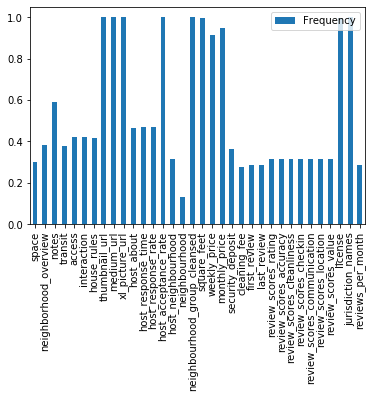

In [63]:
# Detect features with missing values frequency > 0.1
colnames = listing.columns.values  # get all features names in one vector
missfrq['Variables'] = colnames  # add column names variables to missfrq dataframe
misshigh = missfrq[missfrq['Frequency']>0.1]  # Select those frequency value > 0.1
print(misshigh)
misshigh.plot.bar()   # bar plot of missing values

In [64]:
# Remove all features have missing values frequency > 0.1
VarDrop = misshigh['Variables']
listing = listing.drop(VarDrop, axis = 1)  # drop features that have high missing values frequency
print(listing.shape)

(38080, 72)


In [65]:
## (1.2) Impute Missing values for remaining features in listing
missImpute = missfrq[missfrq['Frequency'] != 0]
missImpute = missImpute[missImpute['Frequency'] <= 0.1]  # Select those features with missing values frequency < 0.1
print(missImpute)

                           Frequency                  Variables
name                        0.000341                       name
summary                     0.034769                    summary
description                 0.021586                description
host_name                   0.000683                  host_name
host_since                  0.000683                 host_since
host_location               0.001891              host_location
host_is_superhost           0.000683          host_is_superhost
host_thumbnail_url          0.000683         host_thumbnail_url
host_picture_url            0.000683           host_picture_url
host_listings_count         0.000683        host_listings_count
host_total_listings_count   0.000683  host_total_listings_count
host_has_profile_pic        0.000683       host_has_profile_pic
host_identity_verified      0.000683     host_identity_verified
city                        0.000709                       city
state                       0.007169    

In [66]:
'''There are some unnecessary features such as host_thumbnail_url, host_picture_url, city (all ready have zipcode),
state (all NSW). We will remove these features.
'''
drop = ['host_thumbnail_url','host_picture_url','city','state','host_location','host_since','summary','description','market',
       'name','host_name','zipcode']
listing = listing.drop(drop,axis = 1)
missImpute = missImpute.drop(drop,axis=0)

In [67]:
''' We want to separate continuous and categorical features for missing values imputation.
    Notice that pd.data.describe() only works for continous variable. So we can subset feature names based on this output
    dataframe
'''
missing = listing[missImpute['Variables']]
contmiss = missing.describe().columns.values
catemiss = missImpute.drop(contmiss,axis=0)['Variables'].values

In [68]:
print(contmiss)
print(catemiss)

['host_listings_count' 'host_total_listings_count' 'bathrooms' 'bedrooms'
 'beds']
['host_is_superhost' 'host_has_profile_pic' 'host_identity_verified'
 'cancellation_policy']


In [69]:
# Impute missing values for continuous features
for word in contmiss:
    listing[word] = listing[word].fillna(listing[word].mode()[0])
# Impute missing values for categorical features
import operator
for word in catemiss:
    mode = max(dict(listing[word].value_counts()).items(), key=operator.itemgetter(1))[0]
    listing[word] = listing[word].fillna(value = mode)

In [70]:
listing.isnull().sum()

id                                              0
listing_url                                     0
scrape_id                                       0
last_scraped                                    0
experiences_offered                             0
picture_url                                     0
host_id                                         0
host_url                                        0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
street                                          0
neighbourhood_cleansed                          0
smart_location                                  0
country_code                                    0
country                                         0
latitude                                        0


In [71]:
## (1.3) Checking for duplication
listing.duplicated(['id','host_id'])  # No duplication

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
38050    False
38051    False
38052    False
38053    False
38054    False
38055    False
38056    False
38057    False
38058    False
38059    False
38060    False
38061    False
38062    False
38063    False
38064    False
38065    False
38066    False
38067    False
38068    False
38069    False
38070    False
38071    False
38072    False
38073    False
38074    False
38075    False
38076    False
38077    False
38078    False
38079    False
Length: 38080, dtype: bool

In [72]:
listing.duplicated(['id'])  # No duplication

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
38050    False
38051    False
38052    False
38053    False
38054    False
38055    False
38056    False
38057    False
38058    False
38059    False
38060    False
38061    False
38062    False
38063    False
38064    False
38065    False
38066    False
38067    False
38068    False
38069    False
38070    False
38071    False
38072    False
38073    False
38074    False
38075    False
38076    False
38077    False
38078    False
38079    False
Length: 38080, dtype: bool

In [73]:
listing.duplicated(['host_id'])  # There are duplications but it doesn't matter because one host can have more than 
                                 # 1 property

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23        True
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
38050     True
38051     True
38052    False
38053    False
38054     True
38055    False
38056    False
38057     True
38058     True
38059     True
38060    False
38061    False
38062    False
38063     True
38064    False
38065     True
38066     True
38067    False
38068    False
38069    False
38070    False
38071     True
38072    False
38073     True
38074     True
38075     True
38076     True
38077    False
38078     True
38079     True
Length: 38080, dtype: bool

In [74]:
listing.duplicated()  # there is no exact duplicate of row

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
38050    False
38051    False
38052    False
38053    False
38054    False
38055    False
38056    False
38057    False
38058    False
38059    False
38060    False
38061    False
38062    False
38063    False
38064    False
38065    False
38066    False
38067    False
38068    False
38069    False
38070    False
38071    False
38072    False
38073    False
38074    False
38075    False
38076    False
38077    False
38078    False
38079    False
Length: 38080, dtype: bool

In [75]:
## (1.4) Text feature adjustments and Unnecessary features remove
# Remove unnecessary features
dropvar = ['listing_url','scrape_id','last_scraped','experiences_offered','picture_url','host_url','calendar_last_scraped',
          'calendar_last_scraped','street','smart_location','id','host_id','country_code','country', 
          'amenities','host_verifications']

In [76]:
# Store 'street' feature in a variable
street = listing['street'].copy()

In [77]:
# Keep only names of suburbs of NSW and ignore the term 'NSM, Australia'
for i in range(nrow):
    street[i] = street[i].split(",")[0]

In [78]:
# Store 'smart_location' in a variable
smart_location = listing['smart_location'].copy()

In [79]:
# Keep only names of suburbs of NSW and ignore the term 'NSM, Australia'
for i in range(nrow):
    smart_location[i] = smart_location[i].split(",")[0]

In [80]:
'''
We notice below here is that 'smart_location' and 'street' are identical. So we will drop 'street' and keep the
 'smart_location' for analysis. 
'''
(smart_location == street).unique() # as these two features are idential we will remove one of them (should be 'street')

array([ True])

In [81]:
listing = listing.drop(dropvar,axis = 1)

In [82]:
# Store adjusted features in listing dataset
listing['smart_location'] = smart_location

In [83]:
''' STAGE II:  EXPLORATORY DATA ANALYSIS '''
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

In [84]:
# Make a copy of listing
listcop = listing.copy()
# Create a functio to transform entries in 'price' and 'extra_people' values into quantitative
import string
def clear_punctuation(s):
    clear_string = ""
    for symbol in s:
        if symbol not in string.punctuation:
            clear_string += symbol
    return clear_string
''' Other method also works (for this case):
      string_punctuation = "$,"
      def remove_punctuation(s):
         no_punct = ""
         for letter in s:
            if letter not in string_punctuation:
               no_punct += letter
         return no_punct
'''
# Store 'price' feature in target
target = listcop['price'].copy()
extra_people = listcop['extra_people'].copy()
# Transforming use loop
for i in range(nrow):
    target[i] = int(clear_punctuation(target[i]))/100
    extra_people[i] = int(clear_punctuation(extra_people[i]))/100
listcop = listcop.drop(['price'],axis=1)
listcop = listcop.drop(['extra_people'],axis=1)
listcop['price'] = target
listcop['extra_people'] = extra_people 
listcop = listcop[listcop['price'] != 0]  # drop rows with 0 price
# Convert 'price' and 'extra_people' into numeric type
listcop['price'] = listcop.price.astype(float)
listcop['extra_people'] = listcop.extra_people.astype(float)

We can create a new feature called 'Haversine distance' based on the latitude and longitude available. This can provide some usefull insights as the rental price might be high or low in some specific suburbs away from Sydney CBD. 

In [85]:
from numpy import arcsin
from math import sin, cos, sqrt, radians
## Calculate distance from Sydney CBD
SydLong = listcop[listcop['neighbourhood_cleansed']=='Sydney']['longitude']
SydLat = listcop[listcop['neighbourhood_cleansed']=='Sydney']['latitude']
SydLong_avg = np.mean(SydLong)
SydLat_avg = np.mean(SydLat)

## Create train_distance feature for training set
list_lat = listcop['latitude'].copy().reset_index()
list_long = listcop['longitude'].copy().reset_index()
# Haversine Distance
R = 6373.0  # approximate the earth radius in km
list_distance = [None]*len(list_lat)
for i in range(len(list_lat)):
    CBDlat = radians(SydLat_avg)
    CBDlon = radians(SydLong_avg)
    lat = radians(list_lat['latitude'][i])
    lon = radians(list_long['longitude'][i])
    dlon = lon - CBDlon
    dlat = lat - CBDlat
    haversine = sin(dlat / 2)**2 + cos(CBDlat) * cos(lat) * sin(dlon / 2)**2
    list_distance[i] = 2 * R * arcsin(sqrt(haversine))
# Add Haversine distance feature to dataset
listcop['Haversine distance'] = list_distance
listcop = listcop.drop(['latitude','longitude'],axis=1)  # drop 'latitude' and 'longitude'

Text(0, 0.5, 'Density')

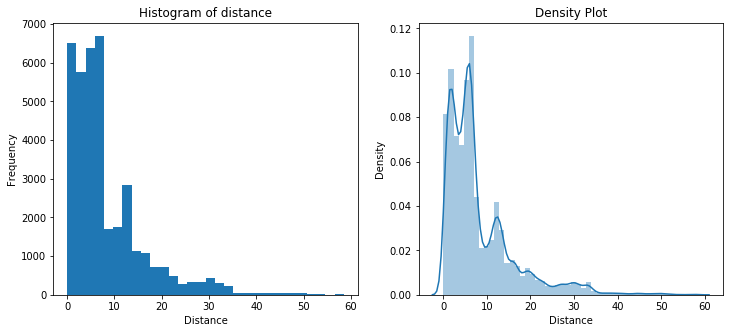

In [86]:
## Visualization of Haversine distance 
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(list_distance,bins=30)
plt.title('Histogram of distance')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.subplot(122,)
sns.distplot(list_distance)
plt.title('Density Plot')
plt.xlabel('Distance')
plt.ylabel('Density')

We can clearly see that there are 3 groupings from the density:
_ Majority of booking frequency gather around places within about 10km from Sydney CBD. 
_ Second majority gather around places within 10km < x < 18km    
_ Last majority gather > 18km.

In [87]:
# Store target and features set
y = listcop['price'].copy()
X = listcop.drop(['price'],axis=1).copy()

In [88]:
## (2.1) Continuous Variables Analysis
contnames = X.describe().columns.values  # continuous feature names
catenames = X.drop(contnames,axis=1).columns.values
X_cont = X[contnames].copy()

' As we can see:\n_ host_lisitings_count, host_total_listings_count, bedrooms, beds, minimum_minimum_nights, maximum_minimum_nights,\n  minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, availability_30,\n  availability_60, availability_90, number_of_reviews, number_of_reviews_ltm, calculated_host_listings_count, \n  calculated_host_listings_count_entire_homes.\n'

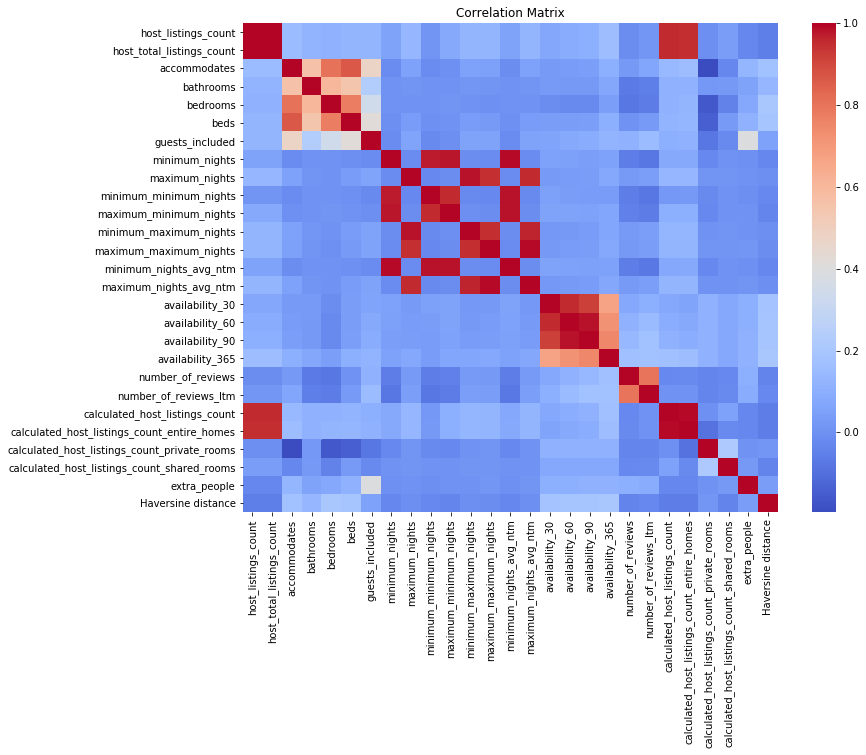

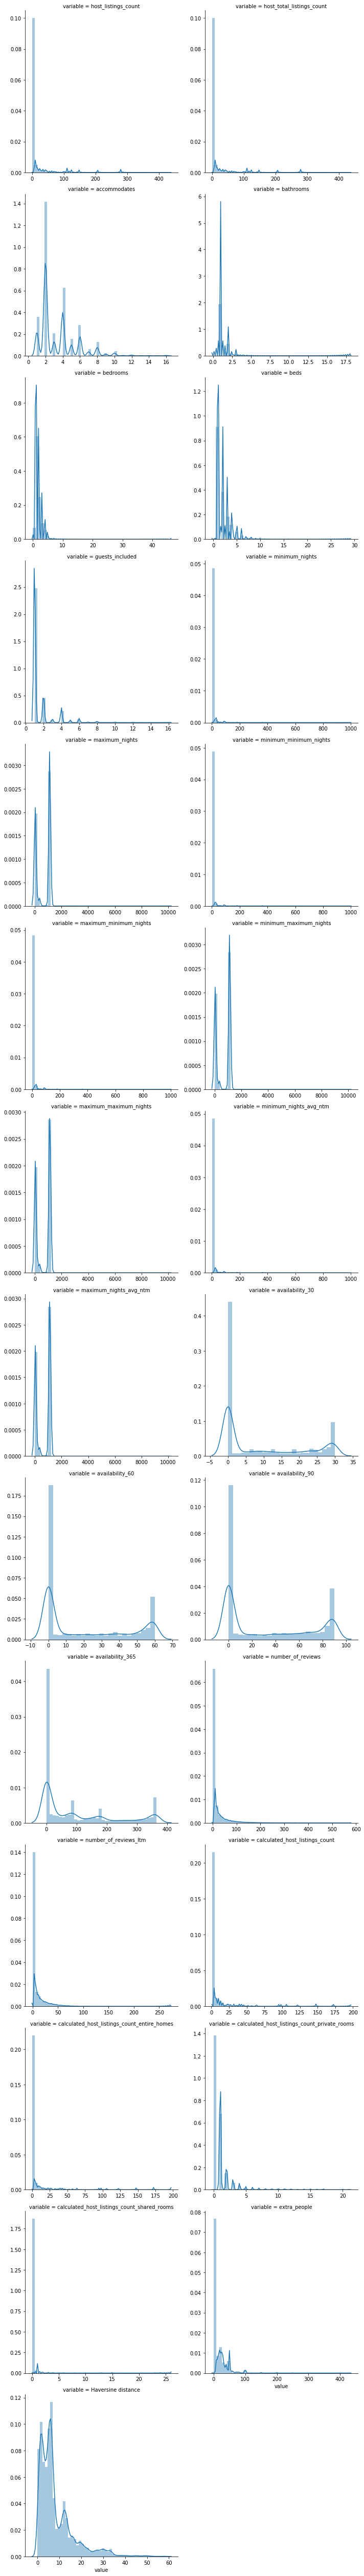

In [89]:
# Correlation matrix between continuous variables
corplot = X_cont.corr() 
# Plot correlation matrix
plt.figure(1,figsize = (12,9))
sns.heatmap(corplot,cmap='coolwarm')
plt.title('Correlation Matrix')
# Plot Scatterplot matrix
f = pd.melt(X_cont)
g = sns.FacetGrid(f,col = "variable",col_wrap=2, sharex=False, sharey=False,height = 5)
g = g.map(sns.distplot,"value")
''' As we can see:
_ host_lisitings_count, host_total_listings_count, bedrooms, beds, minimum_minimum_nights, maximum_minimum_nights,
  minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, availability_30,
  availability_60, availability_90, number_of_reviews, number_of_reviews_ltm, calculated_host_listings_count, 
  calculated_host_listings_count_entire_homes.
'''

In [90]:
# We will see high correlation values (>0.75)
tri_upper = pd.DataFrame(np.triu(corplot,k=1))  # an upper triangular part of correlation matrix (no diagonal)
tri_upper.columns = contnames # set names of this triangular matrix matched with continuous features names
# Choose out feature columns that have high correlation value (>0.75)
highcorr = ['host_listings_count']
for word in contnames:
    if any(tri_upper[word] >= 0.75):
        highcorr.append(word)
highcorr

['host_listings_count',
 'host_total_listings_count',
 'bedrooms',
 'beds',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'availability_60',
 'availability_90',
 'number_of_reviews_ltm',
 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes']

We will keep bedrooms, beds, availability_60, availability_90 as these features might provides useful realtionship with target feature. 
We will drop remaining high correlated features.

In [91]:
# Drop high correlated variables
X = X.drop(['host_total_listings_count','beds','minimum_minimum_nights','maximum_minimum_nights',
                        'minimum_maximum_nights','maximum_maximum_nights','maximum_nights_avg_ntm',
                        'availability_90','number_of_reviews_ltm','calculated_host_listings_count',
                        'calculated_host_listings_count_entire_homes'],axis=1)

X_cont = X_cont.drop(['host_total_listings_count','beds','minimum_minimum_nights','maximum_minimum_nights',
                        'minimum_maximum_nights','maximum_maximum_nights','maximum_nights_avg_ntm',
                        'availability_90','number_of_reviews_ltm','calculated_host_listings_count',
                        'calculated_host_listings_count_entire_homes'],axis=1)

'\n    We can see the target variable is extremely right-skewed. This would highly recommend transformation.\n'

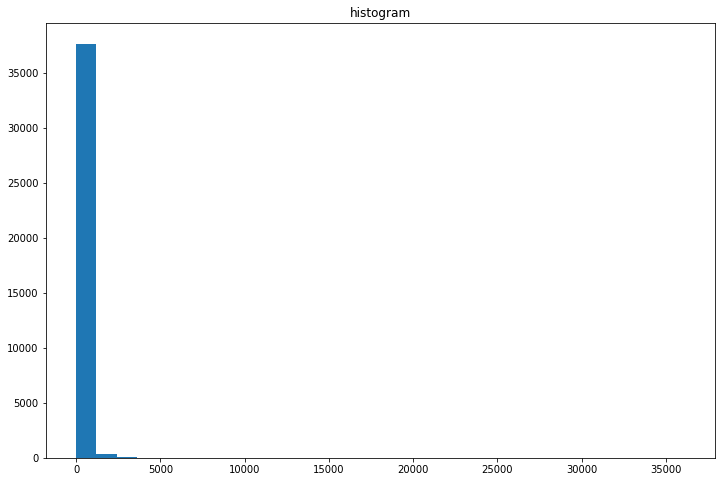

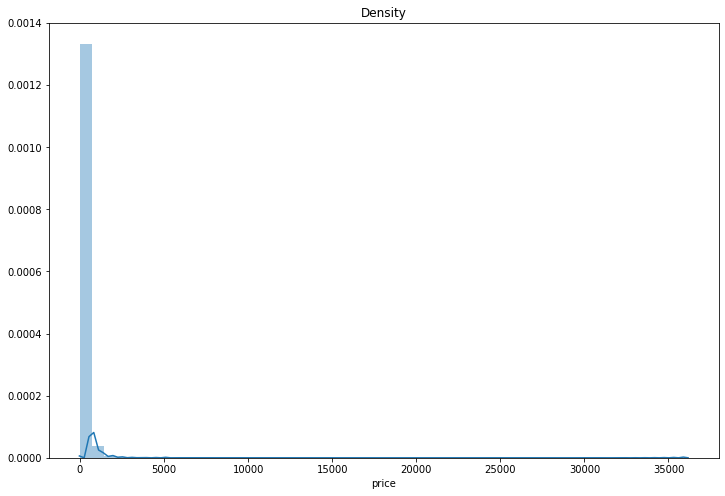

In [92]:
# Density plot of target variable
plt.figure(1, figsize=(12,8))
plt.hist(y,bins = 30)
plt.title('histogram')
plt.figure(2,figsize = (12,8))
sns.distplot(y)
plt.title('Density')

'''
    We can see the target variable is extremely right-skewed. This would highly recommend transformation.
'''

Clearly, from the histogram and density plot above, target features should be transformed. We will try log-transformation.

In [93]:
# Try transform target variable
y_log = y.apply(lambda x: np.log(x))

'\n    Clearly the histogram and density plot of log-transformed target feature seems closer to normal distribution now.\n'

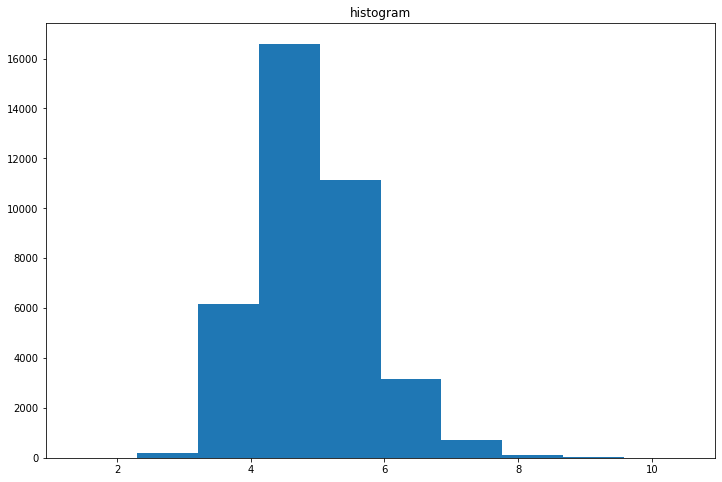

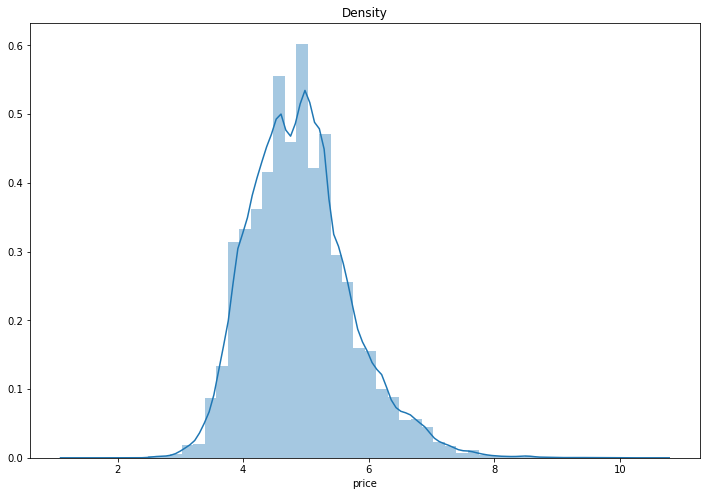

In [94]:
# Plot with new log-transformed target feature
plt.figure(1, figsize=(12,8))
plt.hist(y_log)
plt.title('histogram')
plt.figure(2,figsize = (12,8))
sns.distplot(y_log)
plt.title('Density')

'''
    Clearly the histogram and density plot of log-transformed target feature seems closer to normal distribution now.
'''

The density plot and histogram plot of log-transformed target seems reasonably good.

'Or alternatively,\n    f = plt.figure(figsize=(12,7))\n    for i in range(1, 15):\n        f.add_subplot(5, 3, i)\n        word = contplot.columns.values[i]\n        sns.scatterplot(x=word,y="log-price",data=contplot)\n'

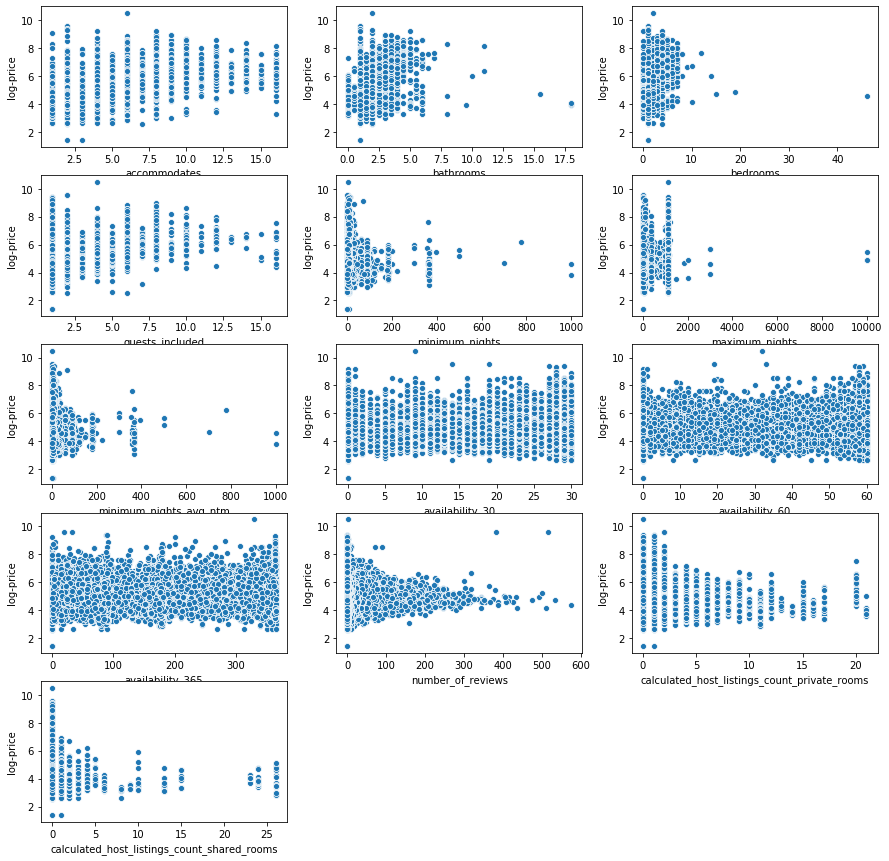

In [95]:
# Scatterplot of continuous features with log-target variable
contplot = X_cont.copy()
contplot['log-price'] = y_log
plt.figure(figsize=(15,15))
for i in range(1, 14):
    plt.subplot(5, 3, i)
    word = contplot.columns.values[i]
    sns.scatterplot(x=word,y="log-price",data=contplot)    
'''Or alternatively,
    f = plt.figure(figsize=(12,7))
    for i in range(1, 15):
        f.add_subplot(5, 3, i)
        word = contplot.columns.values[i]
        sns.scatterplot(x=word,y="log-price",data=contplot)
'''

In [96]:
## (2.2) Categorical Variables Analysis
X_cate = X[catenames].copy()

In [97]:
## Grouping the levels in 'calendar_updated'
calendar_updated=X_cate['calendar_updated'].copy()
calendar_updated = calendar_updated.reset_index() # a new data frame with 2 columns: 'index' (old index column) and 'calendar_updated'
                                                  # this dataframe reset the index to default ranging from [0, 1, .....]
calendar = calendar_updated['calendar_updated'].copy() # make a clean copy of columns 'calendar_updated'
# Adjust the levels in calendar
for i in range(len(calendar)):
    word = calendar[i].split()
    if len(word) == 1:
        if word[0] =='yesterday' or word[0] == 'today':
            word = 'most recently updated'
        elif word[0] == 'never':
            word = 'more than 1 year'
    else:
        if word[0] == 'a': word[0]='1'
        if word[1]=='days' or word[1] =='day':
            word = 'recently updated'
        if word[1]=='week' or word[1] == 'weeks':
            word = 'recently updated'
        if word[1] == 'months' or word[1] == 'month':
            if int(word[0]) <= 12: 
                word = 'less than 1 year'
            else:
                word = 'more than 1 year'
    calendar[i] = word
# 
calendar_updated=calendar_updated.drop(['calendar_updated'],axis=1)  # drop the old 'calendar_updated' columns
calendar_updated['calendar_updated'] = calendar  # create a new 'calendar_updated' column with levels similar to 'calendar'
calendar_updated = calendar_updated.set_index('index') # set the index of dataframe back to original
# Assign new adjusted 'calendar_updated' column to 'X_train'
X = X.drop(['calendar_updated'],axis=1)
X['calendar_updated'] = calendar_updated['calendar_updated']

In [98]:
X['calendar_updated'].value_counts()

less than 1 year         10964
recently updated         10068
more than 1 year          9999
most recently updated     7044
Name: calendar_updated, dtype: int64

In [99]:
## Or we can group by frequency (for the following features below)

In [100]:
## Grouping levels for 'neighbourhodd_cleansed'
X['neighbourhood_cleansed'].value_counts()

Sydney              9745
Waverley            5437
Randwick            3395
Manly               1852
Warringah           1818
Woollahra           1624
North Sydney        1408
Marrickville        1331
Pittwater           1177
Leichhardt           987
Rockdale             764
Ryde                 611
Botany Bay           588
Parramatta           564
Willoughby           553
Sutherland Shire     539
Mosman               533
Auburn               517
Canada Bay           474
Hornsby              401
Canterbury           347
Ku-Ring-Gai          331
Ashfield             318
Lane Cove            313
The Hills Shire      307
Blacktown            302
Bankstown            258
Burwood              248
Hurstville           230
City Of Kogarah      189
Strathfield          177
Liverpool            163
Penrith              145
Holroyd              120
Campbelltown         110
Fairfield             87
Hunters Hill          66
Camden                46
Name: neighbourhood_cleansed, dtype: int64

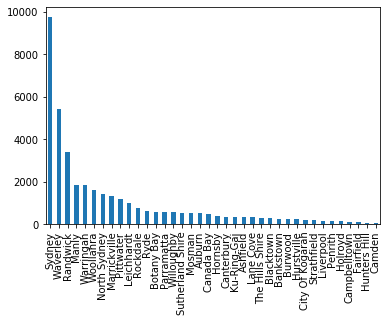

In [101]:
X_cate['neighbourhood_cleansed'].value_counts().plot.bar()

In [102]:
# Create group based on frequency
group1 = X_cate['neighbourhood_cleansed'].value_counts().index[1:7]  # group 1: Estern, Harbours, Beaches
group2 = X_cate['neighbourhood_cleansed'].value_counts().index[7:13] # group 2: Close to CBD (<15 km)
group3 = X_cate['neighbourhood_cleansed'].value_counts().index[13:] # group 3: Other places
# Rename 'Sydney' to 'Sydney CBD'
X['neighbourhood_cleansed'] = X['neighbourhood_cleansed'].replace('Sydney','Sydney CBD')
# Replace each entries with appropriate groupings
for word in group1:
    X['neighbourhood_cleansed'] = X['neighbourhood_cleansed'].replace(word,'Estern, Harbours, Beaches')
for word in group2:
    if word != 'Pittwater':
        X['neighbourhood_cleansed'] = X['neighbourhood_cleansed'].replace(word,'Close to CBD (<15 km)')
for word in group3:
    X['neighbourhood_cleansed'] = X['neighbourhood_cleansed'].replace(word,'Other places')

Text(0.5, 1.0, 'Bar Plot')

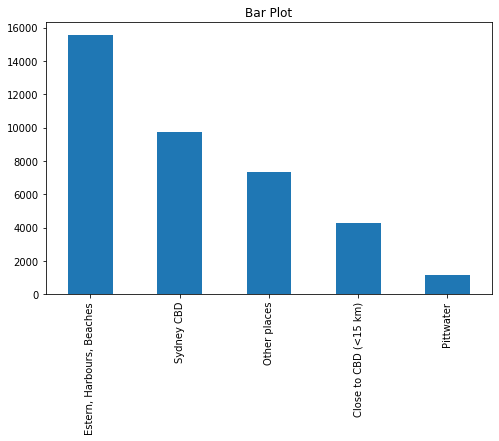

In [103]:
# Visualization
plt.figure(figsize=(8,5))
X['neighbourhood_cleansed'].value_counts().plot.bar()
plt.title('Bar Plot')

Text(0.5, 1.0, 'Barplot')

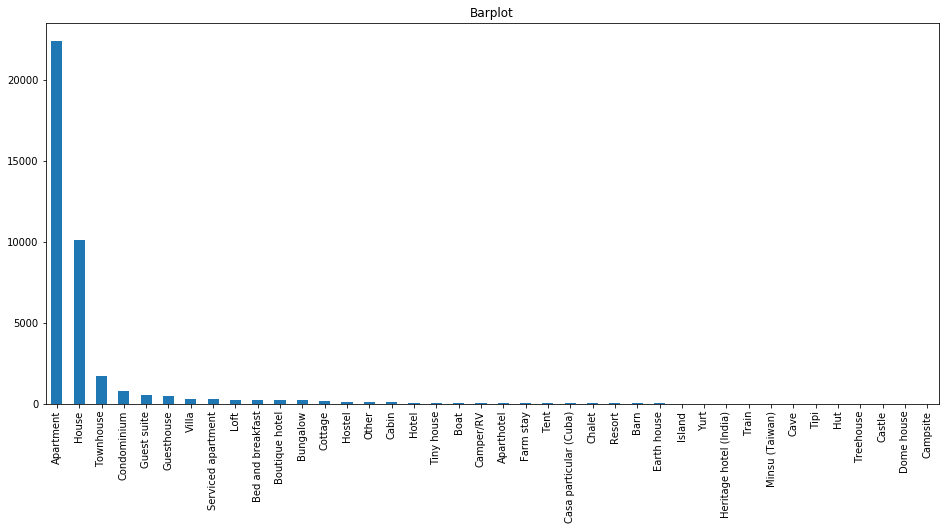

In [104]:
## Working with 'property_type'
# Barplot of property_type
plt.figure(figsize=(16,7))
X_cate['property_type'].value_counts().plot.bar()
plt.title('Barplot')

Notice from the plots (barplots and boxplots) below, there is clearly 3 groupings:
_ Apartment (most frequent)
_ House (second most frequent)
_ Townhouse and others (third most frequent)

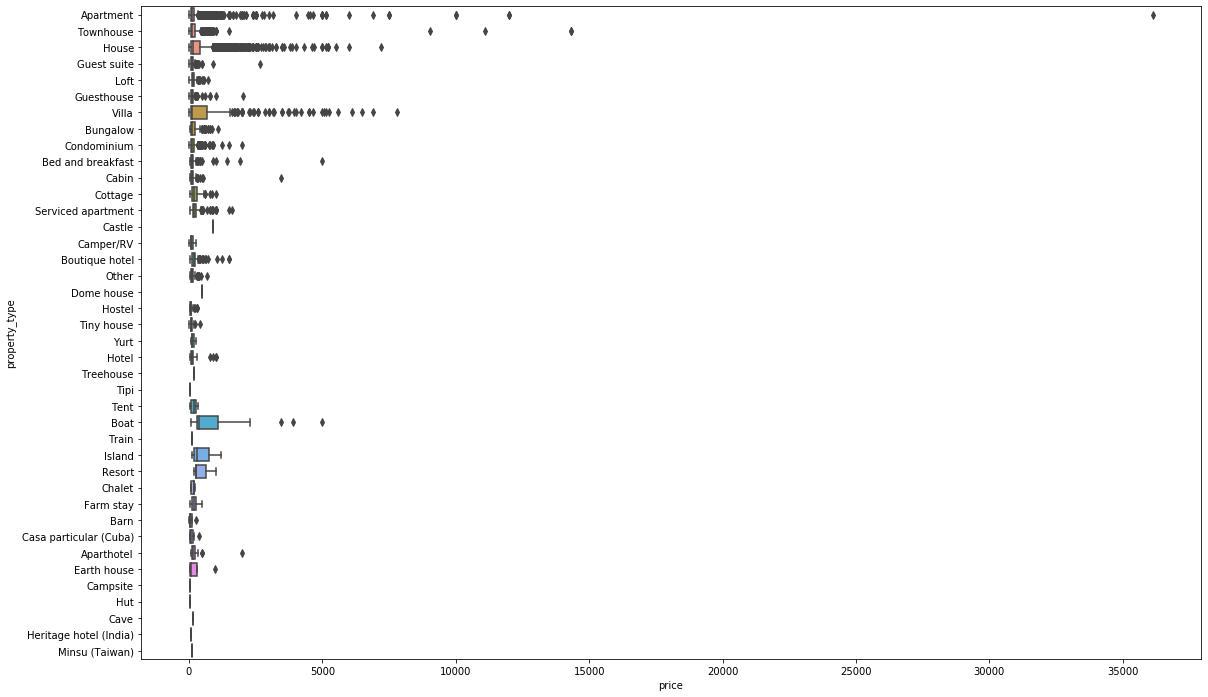

In [105]:
XY= pd.concat([X,y],axis=1).copy() # concatenate X_train and y_train 
# Some boxplot visualization
plt.figure(figsize=(19,12))
sns.boxplot(x='price', y='property_type', data=XY)

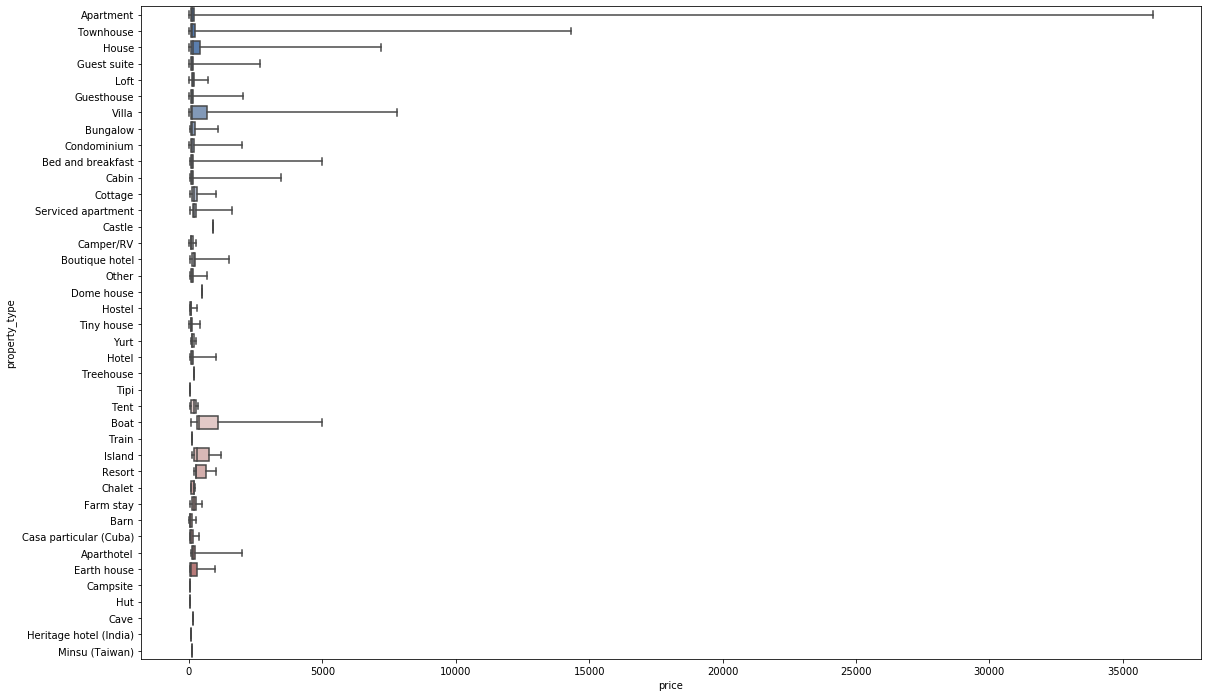

In [106]:
plt.figure(figsize=(19,12))
sns.boxplot(x='price', y='property_type', data=XY,whis="range", palette="vlag")

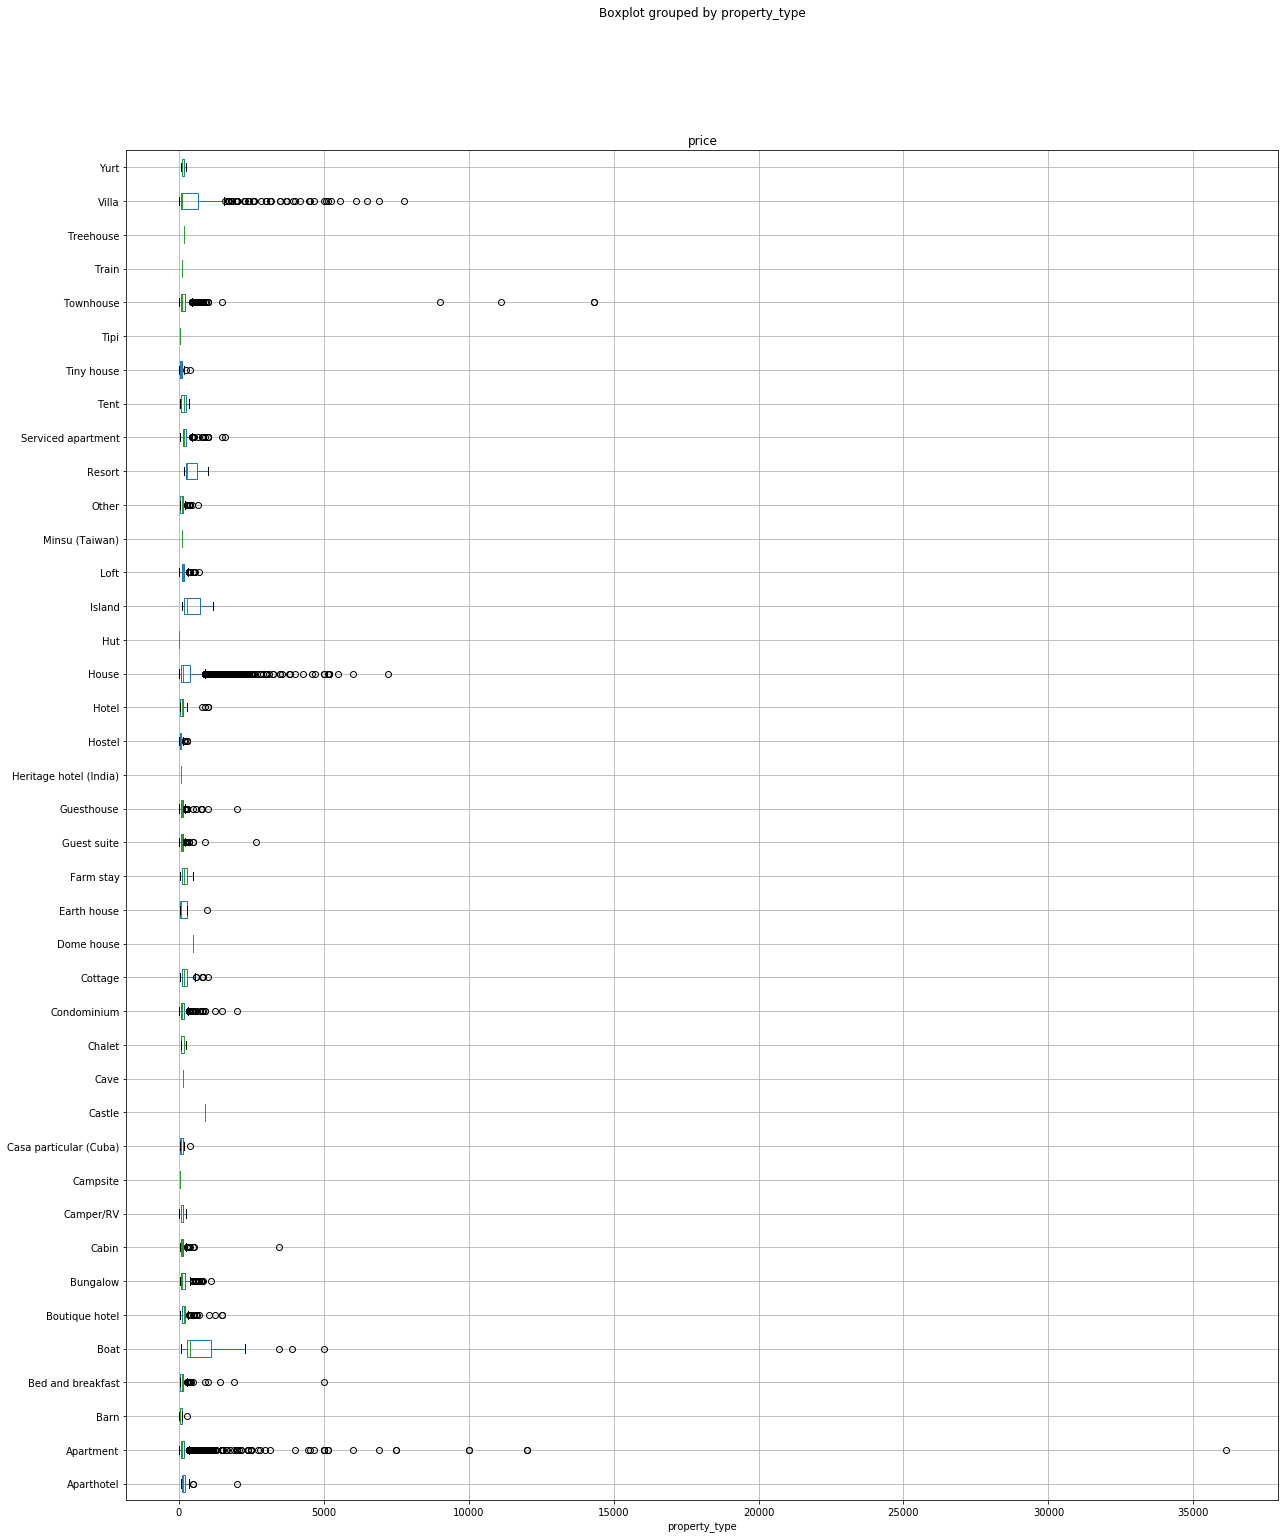

In [107]:
XY.boxplot(column = 'price',by = 'property_type',figsize=(20,25),vert=False)

In [108]:
# modify levels or 'property_type'
groups = X_cate['property_type'].value_counts().index
for word in groups:
    if word != 'Apartment' and word != 'House':
        X['property_type'] = X['property_type'].replace(word,'Townhouse and Others')

In [109]:
## Analysis of 'smart_location'
# Table of frequency of 'smart_location'
Locfreq = X_cate['smart_location'].value_counts().reset_index()
# Rename columns of Locfreq
Locfreq=Locfreq.rename(columns={'index':'smart_location','smart_location':'frequency'})

Text(0.5, 0, 'frequency')

D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 24713 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 23612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\matp

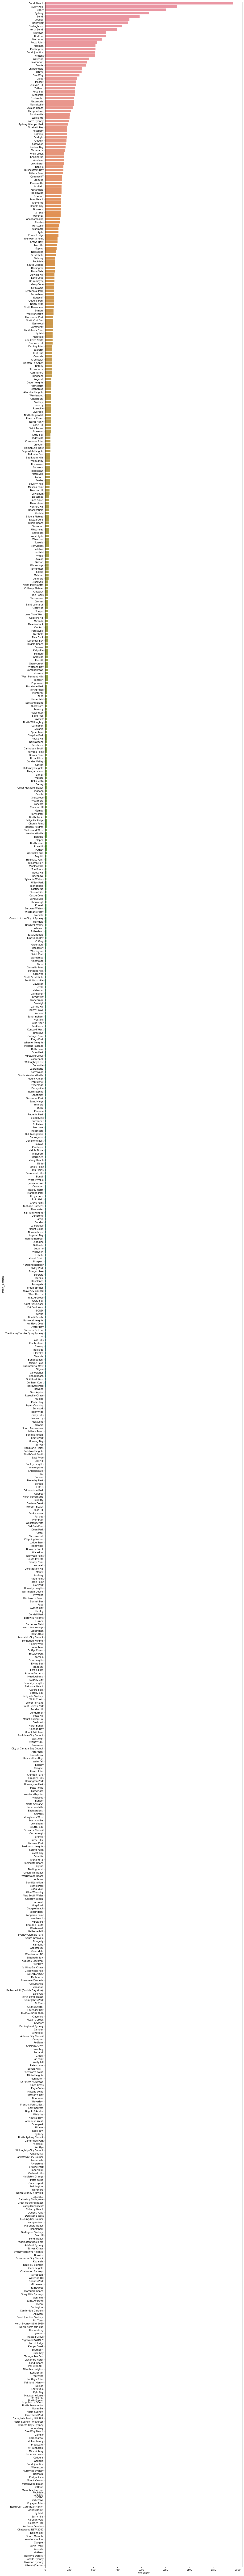

In [110]:
# Barplot of 'smart_location'
plt.figure(figsize=(15,200))
ax = sns.barplot(x='frequency', y='smart_location', data=Locfreq)
ax.set_xlabel('frequency')

In [111]:
group1 = Locfreq[Locfreq['frequency']>300]['smart_location'].unique()
group2 = Locfreq[(Locfreq['frequency']<=300) & (Locfreq['frequency'] >100)]['smart_location'].unique()
group3 = Locfreq[(Locfreq['frequency']<=100) & (Locfreq['frequency'] >10)]['smart_location'].unique()
group4 = Locfreq[Locfreq['frequency']<=10]['smart_location'].unique()

In [112]:
print(sum(Locfreq[Locfreq['frequency']>300]['frequency']))
print(sum(Locfreq[(Locfreq['frequency']<=300) & (Locfreq['frequency'] >100)]['frequency']))
print(sum(Locfreq[(Locfreq['frequency']<=100) & (Locfreq['frequency'] >10)]['frequency']))
print(sum(Locfreq[Locfreq['frequency']<=10]['frequency']))

19325
8939
8325
1486


In [113]:
# Modify level of 'smart_location'
for word in group1:
    X['smart_location'] = X['smart_location'].replace(word,'Top group')
for word in group2:
    X['smart_location'] = X['smart_location'].replace(word,'1st Middle group')
for word in group3:
    X['smart_location'] = X['smart_location'].replace(word,'2nd Middle group')
for word in group4:
    X['smart_location'] = X['smart_location'].replace(word,'Bottom group')

In [114]:
# Create vector of p-values from chi-squared test between categorical features
depend_cate=[]
for i in range(len(catenames)):
    word1 = catenames[i]
    j = i+1
    while j < len(catenames):
        word2 = catenames[j]
        conting_table = pd.crosstab(X[word1],X[word2],margins=False)
        p_value = stats.chi2_contingency(conting_table)[1]
        if p_value < 0.05:
            depend_cate.append([word1,word2,p_value])
        j+=1
# Check out association between categorical features where p-value < 0.05
pd.DataFrame(depend_cate).head(80)

,0,1,2
0,host_is_superhost,host_has_profile_pic,5.812952e-03
1,host_is_superhost,host_identity_verified,1.454840e-26
2,host_is_superhost,neighbourhood_cleansed,9.441147e-77
3,host_is_superhost,is_location_exact,1.615504e-10
4,host_is_superhost,property_type,5.077398e-91
5,host_is_superhost,room_type,1.241836e-29
6,host_is_superhost,bed_type,4.436348e-02
7,host_is_superhost,calendar_updated,0.000000e+00
8,host_is_superhost,instant_bookable,8.133942e-08
9,host_is_superhost,cancellation_policy,3.527750e-232


We will see asscociation measure between categorical features and target variable.

In [115]:
# Create anova function 
from scipy import stats
XY = pd.concat([X,y_log],axis=1)
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = catenames
    pvals = []
    for word in catenames:
        samples = []
        for level in frame[word].unique():
            s = frame[frame[word] == level]['price'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\scipy\stats\stats.py:2959: RuntimeWarning: invalid value encountered in double_scalars
  msb = ssbn / dfbn
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


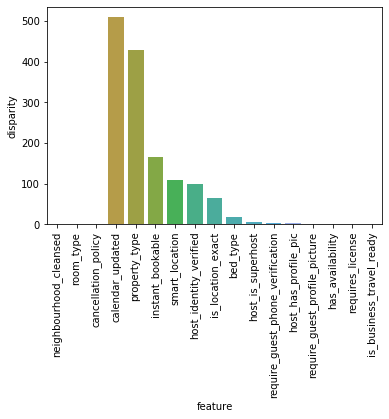

In [116]:
# plot association
a = anova(XY)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

It is suggested that we should remove redundant features including 'host_has_profile_pic','neighbourhood_cleansed', 
'require_guest_profile_picture','is_business_travel_ready','require_guest_phone_verification',
           'requires_license','has_availability'. 

In [117]:
X = X.drop(['host_has_profile_pic','neighbourhood_cleansed', 
'require_guest_profile_picture','is_business_travel_ready','require_guest_phone_verification',
           'requires_license','has_availability'],axis=1)

In [118]:
''' STAGE III: MODEL FITTING 
_ Models including: Linear Regression, LASSO, Ridge Regression, Decision Trees, Random Forest, Gradient Boosting Machine,
                    XGBoost, AdaBoost, EM algorithm.
'''
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
# Import data
dat = X.copy()
tar = y.copy()
tar_log = tar.apply(lambda x: np.log(x))

In [119]:
''' Label Encoding for categorical features '''
contnames = dat.describe().columns.values
catenames = dat.drop(contnames,axis=1).columns.values
# Using LabelEncoder
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
dat[catenames] = dat[catenames].apply(lambda col: label.fit_transform(col))

In [120]:
# Splitting data
dat_train, dat_test, tar_train, tar_test = train_test_split(dat, tar_log, test_size = .30, random_state = 50)

In [122]:
# Standardizing continuous variables
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dat_train[contnames] = scaler.fit_transform(dat_train[contnames])
dat_test[contnames] = scaler.fit_transform(dat_test[contnames])

D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
D:\0. TQUANT-Resources\IDEs\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [123]:
'''(1): Linear Regression'''
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error  # for model accuracy and evaluation

In [124]:
# Create and fit model
regression = LinearRegression()
regression.fit(dat_train,tar_train)
# View intercept
print(regression.intercept_)
# View feature coefficients
print(regression.coef_)
# Make prediction
predictions = regression.predict(dat_test)
# R-Square
print('R-squared: %.2f' % regression.score(dat_test,tar_test))
# mean square error
print('MSE: {}'.format(mean_squared_error(tar_test,predictions)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(tar_test,predictions))))

4.903821764762727
[ 0.03705982  0.03656417  0.01297248 -0.00333295  0.02303365 -0.59770079
  0.19790203  0.08870813  0.19035849  0.05972312 -0.03987006 -0.05929768
 -0.00413887  0.04424754  0.09520409 -0.04815532  0.06032993 -0.03279094
 -0.06465762  0.00488053 -0.025627   -0.02905499  0.03312963  0.01419193
 -0.07409988 -0.04028624]
R-squared: 0.63
MSE: 0.2470938040044027
RMSE: 0.49708530857831906


In [125]:
'''(2): Stochastic Gradient Descent''' 
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(loss ='squared_loss')
sgd_reg.fit(dat_train, tar_train)
sgd_predictions = sgd_reg.predict(dat_test)
# Using cross validation k = 5
scores = cross_val_score(sgd_reg, dat_train, tar_train, cv=5)
print(scores)
# mean square error
print('MSE: {}'.format(mean_squared_error(tar_test,sgd_predictions)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(tar_test,sgd_predictions))))

[0.60873371 0.59060551 0.59736791 0.60147272 0.62039157]
MSE: 0.2718034952787122
RMSE: 0.5213477680768492


In [126]:
'''(3): Ridge Regression'''
from sklearn.linear_model import Ridge
classifier = Ridge()
ridmod = classifier.fit(dat_train,tar_train)  # create models
ridpred = ridmod.predict(dat_test) # predictions
# R-Square
print('R-squared: %.2f' % ridmod.score(dat_test,tar_test))
# mean square error
print('MSE: {}'.format(mean_squared_error(ridpred,tar_test)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(ridpred,tar_test))))

R-squared: 0.63
MSE: 0.24709198612502992
RMSE: 0.49708348003633146


In [127]:
'''(4): Decision Trees'''
from sklearn.tree import DecisionTreeRegressor
# Store features matrix and target vector
tree = DecisionTreeRegressor(criterion='mse',     # Initialize and fit regressor
                             max_depth=6) 
treemod = tree.fit(dat_train,tar_train)
treepred = treemod.predict(dat_test)
# mean squared error
print('MSE: {}'.format(mean_squared_error(treepred,tar_test)))

MSE: 0.22614040251012596


In [128]:
'''(5): Random Forest '''
from sklearn.ensemble import RandomForestRegressor 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regmod = regressor.fit(dat_train, tar_train) # creat model
regpred = regmod.predict(dat_test)  # Predictions
# mean squared error
print('MSE: {}'.format(mean_squared_error(regpred,tar_test)))

MSE: 0.19462547320072845


Clearly, the random forest out-perform other models with the mean squared error less than 20%. 